# Demonstration: low-pass additive white gaussian noise (AWGN)

In [1]:
# import necessary libraries
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import math
from scipy import signal

# Show all plots inline (not in new window)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
matplotlib.rcParams['font.size'] = 18

## Generate sampled signal consisting of noisy samples

### Generate noisy samples
draw real and imaginary part of each sample from normal distribution:

In [2]:
# Time reference: 
T_S = 1e-6          # seconds
f_S = 1 / T_S       # sampling frequency
f_nyquist = f_S / 2 # nyquist frequency

print('Nyquist frequency = {} kHz'.format(f_nyquist/1000))

Nyquist frequency = 500.0 kHz


In [3]:
N_0 = 1;                     # W/Hz
variance = N_0*f_S/2         # variance of each component (I, Q)
sigma = math.sqrt(variance)  # standard deviation of each component
num_samples = 10000          # number of samples (= length of vector)

complex_noisy_samples = np.random.normal(0, sigma, num_samples) \
                      + 1j * np.random.normal(0, sigma, num_samples)

### Noise samples in complex plane

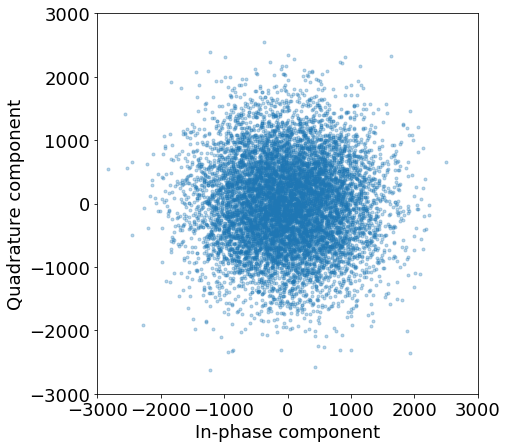

In [4]:
plt.figure(figsize=(7, 7)); plt.axis('square');
plt.scatter(complex_noisy_samples.real, complex_noisy_samples.imag, marker='.', alpha=0.3)
plt.xlim(-3000, 3000); plt.ylim(-3000, 3000)
plt.xlabel('In-phase component'); plt.ylabel('Quadrature component');

Can you see the gaussian bell?

## Visualize Noise

### Time domain of I and Q Components

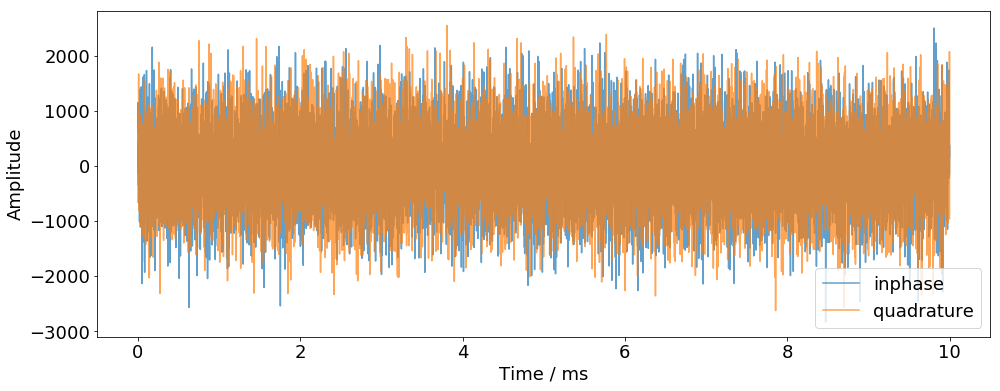

In [5]:
t = np.arange(num_samples) * T_S  # vector of sampling time instances

plt.plot(t*1e3, complex_noisy_samples.real, t*1e3, complex_noisy_samples.imag, alpha=0.7)
plt.xlabel('Time / ms'); plt.ylabel('Amplitude'); plt.legend(('inphase', 'quadrature'));


### Autocorrelation function (normalized)

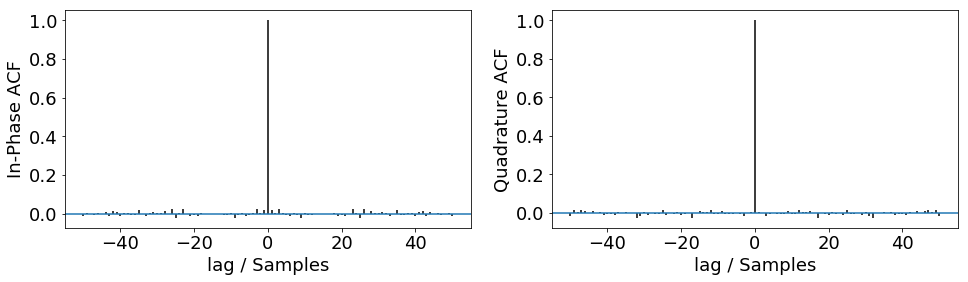

In [6]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.acorr(complex_noisy_samples.real, usevlines=True, maxlags=50)
plt.ylabel('In-Phase ACF'); plt.xlabel('lag / Samples'); plt.axis('tight')

plt.subplot(122)
plt.acorr(complex_noisy_samples.imag, usevlines=True, maxlags=50)
plt.ylabel('Quadrature ACF'); plt.xlabel('lag / Samples'); plt.axis('tight');

### Histogram and comparison with probability density funciton of normal distribution

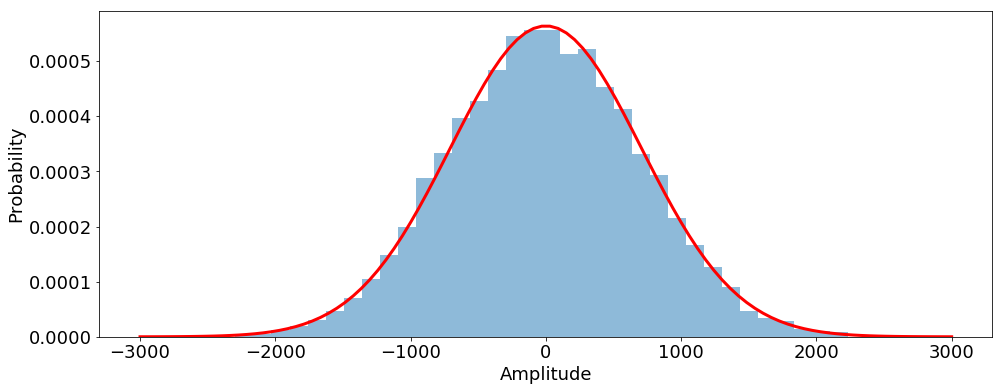

In [7]:
# Plot normalized histogram
plt.hist(complex_noisy_samples.real, bins=40, normed=True, alpha=0.5);
plt.xlabel('Amplitude'); plt.ylabel('Probability')

# Plot normal distribution
x = np.linspace(-3000, 3000, 100)
plt.plot(x,mlab.normpdf(x, 0, sigma), 'r', linewidth=3.0);

Amplitudes are normally distributed. Try to play with number of samples and number of bins. Yo may also want to take a look at histogram of quadrature component. **What do you expect?**

### Power spectral density using welch method

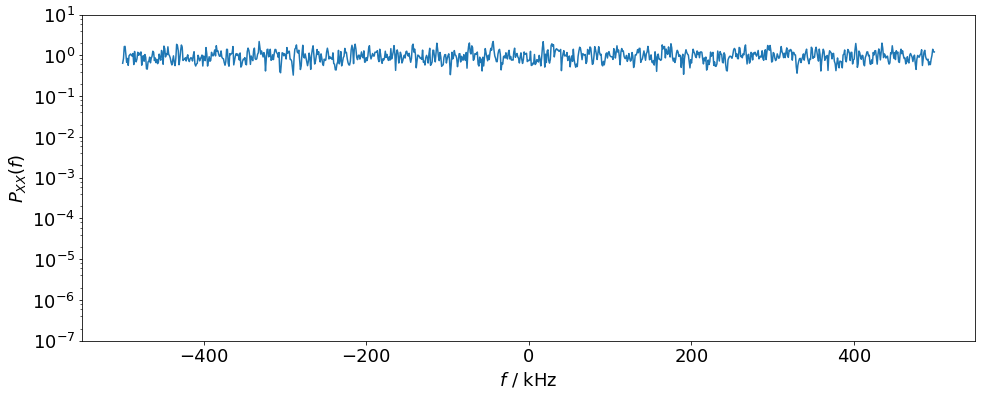

In [8]:
Pxx, freqs = mlab.psd(complex_noisy_samples, NFFT=1024, Fs=f_S, window=mlab.window_hanning, noverlap=0)

# Plot PSD, use logarithmic scale:
plt.semilogy(freqs / 1000, Pxx)
plt.axis('tight'); plt.ylim(1e-7, 1e1)
plt.ylabel('$P_{XX}(f)$'); plt.xlabel('$f$ / kHz');

Not quite a constant, why not?

## Low-Pass filtered Gaussian noise

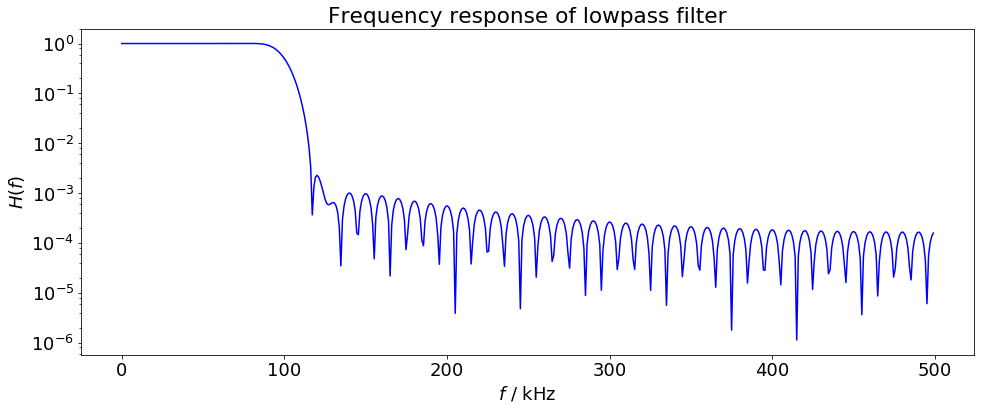

In [9]:
cutoff_freq = 100000  # cutoff frequency of lowpass filter: 100 kHz
numtaps = 101         # number of filter taps 

# FIR filter design:
lpass_taps = signal.firwin(numtaps, cutoff_freq, nyq=f_nyquist)  #  Get filter taps
freq_norm, response = signal.freqz(lpass_taps) # filter response in frequency domain
freq = freq_norm * f_nyquist / np.pi

# Plot frequency response:
plt.semilogy(freq / 1e3, abs(response), 'b-') 
plt.title('Frequency response of lowpass filter'); plt.ylabel('$H(f)$'); plt.xlabel('$f$ / kHz');

### Filter noisy samples (now actually we generate low-pass filtered gaussian noise)

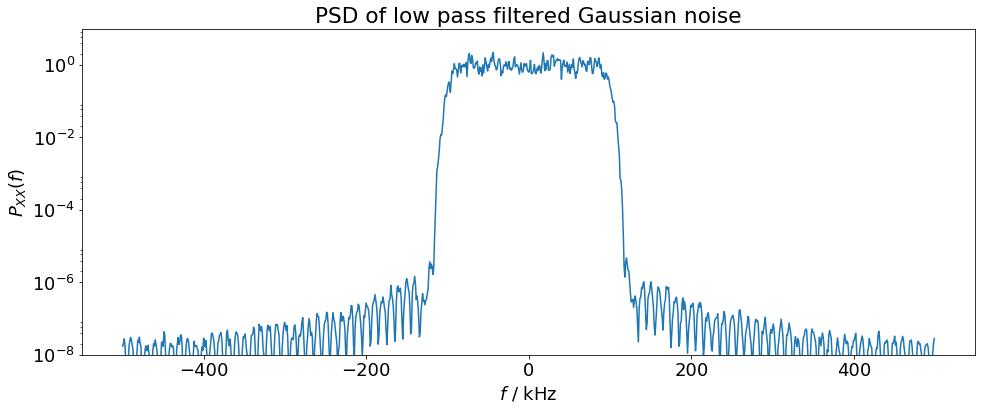

In [10]:
# Filter noise with lowpass:
filtered_x = signal.lfilter(lpass_taps, 1.0, complex_noisy_samples)

# Calculate PSD:
Pxx, freqs = mlab.psd(filtered_x, NFFT=1024, Fs=f_S, window=mlab.window_hanning, noverlap=0)

# Plot PSD, use logarithmic scale:
plt.semilogy(freqs / 1000, Pxx); plt.title('PSD of low pass filtered Gaussian noise');
plt.axis('tight'); plt.ylim(1e-8, 1e1); plt.ylabel('$P_{XX}(f)$'); plt.xlabel('$f$ / kHz');

### Autocorrelation function (normalized)

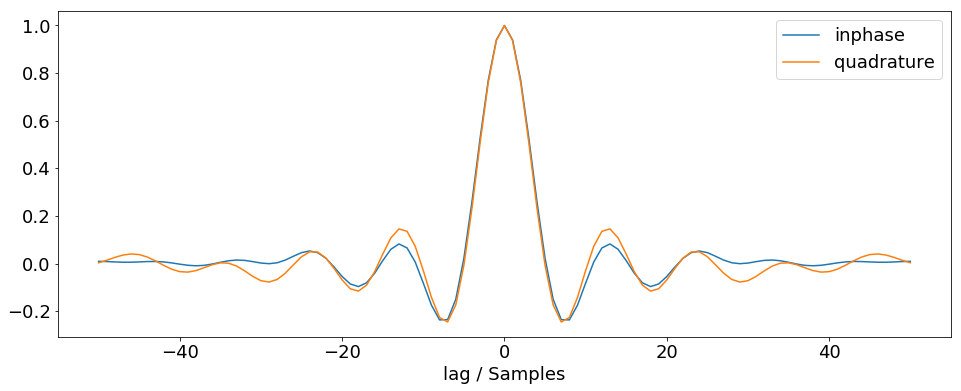

In [11]:
plt.acorr(filtered_x.real, usevlines=False, maxlags=50, marker=None, linestyle='-')
plt.acorr(filtered_x.imag, usevlines=False, maxlags=50, marker=None, linestyle='-')
plt.xlabel('lag / Samples'); plt.axis('tight'); plt.legend(('inphase', 'quadrature'));

If you compare this with the autocorrelation function of the unfiltered noise, can you explain what happened?

### Downsampling

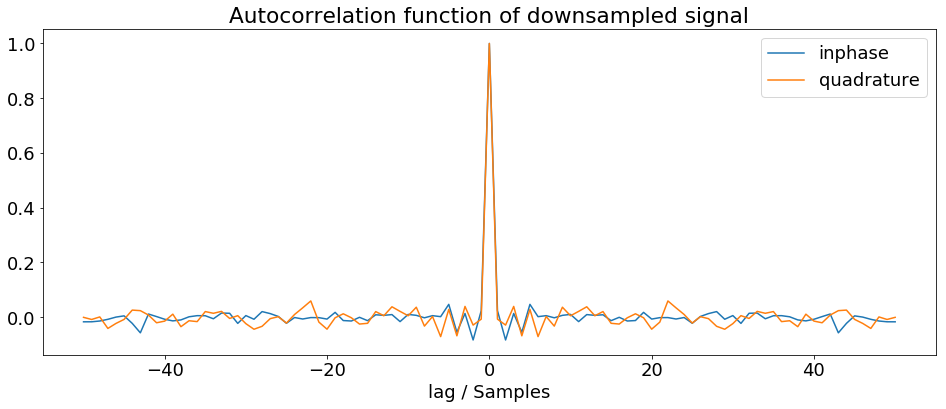

In [12]:
# Take every 5th element of filtered signal
factor = 5; filt_x_dwnsampled = filtered_x[::factor]
plt.acorr(filt_x_dwnsampled.real, usevlines=False, maxlags=50, marker=None, linestyle='-')
plt.acorr(filt_x_dwnsampled.imag, usevlines=False, maxlags=50, marker=None, linestyle='-')
plt.title('Autocorrelation function of downsampled signal')
plt.xlabel('lag / Samples'); plt.axis('tight'); plt.legend(('inphase', 'quadrature'));

What happened? Why did we take every 5th sample? 
Hint: take a look at the cutoff frequency of the filter and at the nyquist frequency.

### PSD after downsampling

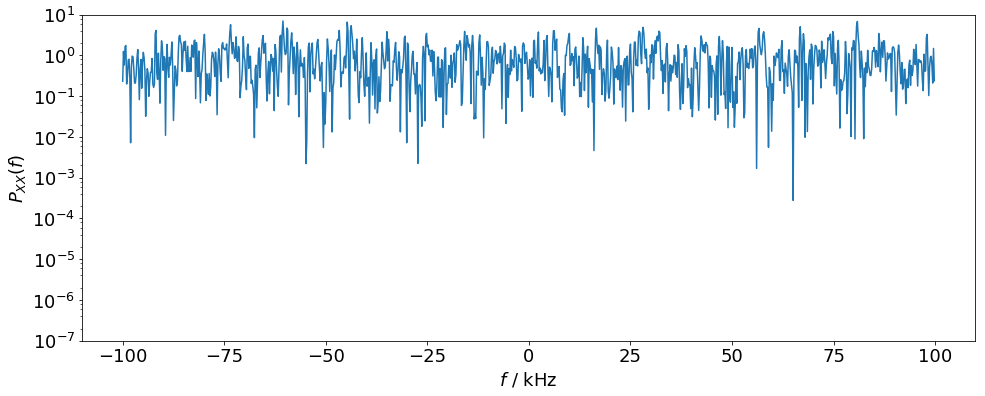

In [13]:
Pxx, freqs = mlab.psd(filt_x_dwnsampled, NFFT=1024, Fs=f_S/factor, window=mlab.window_hanning, noverlap=0)

# Plot PSD, use logarithmic scale:
plt.semilogy(freqs / 1000, Pxx)
plt.axis('tight'); plt.ylim(1e-7, 1e1)
plt.ylabel('$P_{XX}(f)$'); plt.xlabel('$f$ / kHz');

Author: Johannes Fink, April 2016. Johannes.Fink@kit.edu